# CNN (Image Classification Analysis)

+ Requirements:
    1. The file "mean_and_std.csv" is required.
    2. The estimated time to carry out this activity is approximately 1 hour.
<br><br>
+ Objectives of the notebook:
    1. Introduction to Pytorch
    2. Understand how to apply CNNs to image classification
<br><br>
+ Summary of activities:
    1. To achieve these objectives, we will analyze pieces of code in Pytorch.
<br><br>

%%latex
\tableofcontents
\newpage

# Sample code in Pytorch
Below is a Pytorch code example of a convolutional neural network and its training for the cifar10 dataset.

- In Python you always start by importing all the required modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
import pandas as pd
import torchvision.models as models
import ipywidgets as widgets               # functionality of interaction with graphs

- The dataset is created with the input data and the outputs of the function (or labels).

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

#---------------------------------------------------------------------------------------------
# Initiating some important hiperparameters
path, name, epochs = 'datasets/CIFAR10/', 'cifar10', 13 # training time -> approx. 6 minutes per epoch
my_batch_size=16

#---------------------------------------------------------------------------------------------
# Loading and normalizing CIFAR10

# # Get normalization parameters (execute only once)
# transform = transforms.Compose([transforms.ToTensor(),])
# set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# setloader = torch.utils.data.DataLoader(set, batch_size=my_batch_size,shuffle=False, num_workers=0)
#
# def online_mean_and_sd(loader):
#     """Compute the mean and sd in an online fashion
#
#         Var[x] = E[X^2] - E^2[X]
#     """
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)
#
#     for data, labels in loader:
#         b, c, h, w = data.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(data, dim=[0, 2, 3])
#         sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
#         cnt += nb_pixels
#
#     return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
#
# mean, std = online_mean_and_sd(setloader)
# mean_and_std = np.concatenate((mean.numpy(),std.numpy()),axis=0)
# pd.DataFrame(mean_and_std).to_csv(path+'mean_and_std.csv',index=False)

pd_data = pd.read_csv('mean_and_std.csv').values  # Read data file.
mean = (pd_data[0,0], pd_data[1,0], pd_data[2,0]) # 3 firsts columns --> mean
std  = (pd_data[3,0], pd_data[4,0], pd_data[5,0]) # 3 last column --> std

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_validation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=path+'data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=my_batch_size,
                                          shuffle=True, num_workers=0)

validationset = torchvision.datasets.CIFAR10(root=path+'data', train=False,
                                       download=True, transform=transform_validation)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=my_batch_size,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car  ', 'bird ', 'cat  ', 'deer ', 'dog  ', 'frog ', 'horse', 'ship ', 'truck')
n_classes = len(validationset.classes)

Using device: cpu



0it [00:00, ?it/s]

Extracting datasets/CIFAR10/data\cifar-10-python.tar.gz to datasets/CIFAR10/data
Files already downloaded and verified


- A CNN model is defined using the Pytorch functionality:

In [3]:
#---------------------------------------------------------------------------------------------
# Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)        # (3x5x5+1)x6 parameters
        #self.conv1 = nn.Conv2d(3, 12, 5)  # (3x5x5+1)x12 parameters
        #self.cnn_bn1 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)         # 0 parameters
        self.conv2 = nn.Conv2d(6, 16, 5)       # (6x5x5+1)x16 parameters
        #self.conv2 = nn.Conv2d(12, 16, 5)  # (12x5x5+1)x16 parameters
        #self.cnn_bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # (16x5x5+1)x120 parameters
        #self.bn1 = nn.BatchNorm1d(num_features=120)
        #self.fc1 = nn.Linear(16 * 5 * 5, 240)  # (16x5x5+1)x120 parameters
        #self.bn1 = nn.BatchNorm1d(num_features=240)
        #self.drop1d = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)          # (120+1)x84 parameters
        # self.bn2 = nn.BatchNorm1d(num_features=84)
        #self.fc2 = nn.Linear(240, 168)          # (120+1)x84 parameters
        #self.bn2 = nn.BatchNorm1d(num_features=168)
        self.fc3 = nn.Linear(84, 10)           # (84+1)x10 parameters
        #self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))    # 3x32x32 inputs -> 6x28x28 activation maps -> 6x14x14 activation maps
        x = self.pool(F.elu(self.conv2(x)))    # 16x10x10 activation maps -> 16x5x5 activation maps
        x = x.view(-1, 16 * 5 * 5)
        x = F.elu(self.fc1(x))                 # 400 inputs -> 120 outputs
        x = F.elu(self.fc2(x))                 # 120 inputs -> 84 outputs
        x = self.fc3(x)                        # 84 inputs -> 10 outputs

        # x = self.pool(F.elu(self.cnn_bn1(self.conv1(x))))    # 3x38x38 inputs -> 6x28x28 activation maps -> 6x14x14 activation maps
        # x = self.pool(F.elu(self.cnn_bn2(self.conv2(x))))    # 16x10x10 activation maps -> 16x5x5 activation maps
        # x = x.view(-1, 16 * 5 * 5)
        # x = F.elu(self.drop1d(self.bn1(self.fc1(x))))                 # 400 inputs -> 120 outputs
        # x = F.elu(self.drop1d(self.bn2(self.fc2(x))))                 # 120 inputs -> 84 outputs
        # x = self.fc3(x)                        # 84 inputs -> 10 outputs
        return x

In [4]:
#---------------------------------------------------------------------------------------------
# Auxiliar functions to show an image
def imshow(img, unnormalize=True, rgb = True):
    if unnormalize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if rgb:
        npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

- The parameters of the model are estimated:

In [5]:
checkbox_train = widgets.Checkbox(value=False, description='Model training', disabled=False)
display(checkbox_train)

Checkbox(value=False, description='Model training')


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Epoch 0 - Training loss: 1.6007 - Validation accuracy: 0.4966 at iter 3125 *
Epoch 1 - Training loss: 1.3516 - Validation accuracy: 0.5499 at iter 6250 *
Epoch 2 - Training loss: 1.2444 - Validation accuracy: 0.6008 at iter 9375 *
Epoch 3 - Training loss: 1.1795 - Validation accuracy: 0.6067 at iter 12500 *
Epoch 4 - Training loss: 1.1345 - Validation accuracy: 0.6340 at iter 15625 *
Epoch 5 - Training loss: 1.0998 - Validation accuracy: 0.6436 at iter 18750 *
Epoch 6 - Training loss: 1.0802 - Validation accuracy: 0.6268 at iter 21875  
Epoch 7 - Training loss: 1.0551 - Validation accuracy: 0.6505

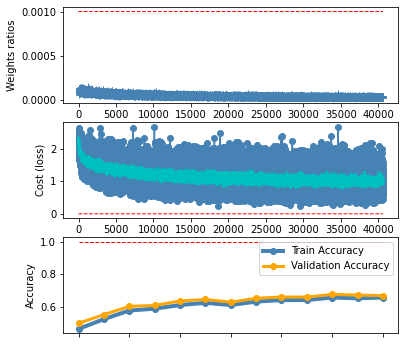




In [6]:
#---------------------------------------------------------------------------------------------
# Supervised Training.

if checkbox_train.value:
    # Initializing weights
    # # Optimization starting from random weights
    net = Net()
    best_validation_accuracy = 0.

    # # Optimization starting from the last model weights
    # net = torch.load(name + '_relu_model.pth')
    # best_validation_accuracy = 0.6555

    # net = torch.load(name + '_elu_model.pth')
    # best_validation_accuracy = 0.6571

    # net = torch.load(name + '_model.pth')
    # best_validation_accuracy = 0.7179

    # net = torch.load(name + '_elu_ad_model.pth')
    # best_validation_accuracy = 0.7276

    print()
    print(net)
    print()

    net.train()
    if torch.cuda.is_available(): 
        net.cuda()

    # Define a Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    learning_rate = 0.001 # 0.001
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    # functions to get training or evaluation accuracy
    def get_accuracy(my_model, my_loader, device):
        ''' Function for returning accuracy of a model for a mnist loader data.
        '''
        correct_count, all_count = 0, 0
        for images, labels in my_loader:
            images = images.to(device)
            labels = labels.to("cpu")

            for i in range(len(labels)):
                with torch.no_grad():
                    outputs = my_model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_count += labels.size(0)
                correct_count += (predicted.to("cpu") == labels).sum().item()
        return(correct_count / all_count)

    time0 = time()

    max_iter = trainloader.__len__()*epochs
    cost = np.zeros((max_iter, 1))
    ucost = np.zeros((max_iter, 1))

    acc = []
    # net.eval()
    # acc_eval = get_accuracy(net, validationloader)
    # net.train()
    # acc_train = get_accuracy(net, trainloader)
    # acc.append([acc_train, acc_eval])

    # It is important to be sure that model is in mode train()
    net.train()

    weight_ratios = np.zeros((max_iter, 1))
    t, c_ant, beta = 0, 0, 0.9

    for e in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # This is where the model learns by backpropagating
            # Gradient calculation.
            weights = net.fc1.weight.data.to("cpu").numpy().ravel()
            loss.backward()
            grads_lr = net.fc1.weight.grad.to("cpu").numpy().ravel() * learning_rate
            weight_ratios[t] = np.linalg.norm(grads_lr) / np.linalg.norm(weights)

            # # Visualize weights parameters
            # for name, m in net._modules.items():
            #     if 'conv' in name:
            #         kernels = m.weight.detach()
            #         fig, axarr = plt.subplots(kernels.size(0), kernels.size(1))
            #         for idx in range(kernels.size(0)):
            #             for jdx in range(kernels.size(1)):
            #                 img = normalize_output(kernels[idx,jdx,:,:].squeeze().view(kernels.size(2),kernels.size(3)))
            #                 axarr[idx, jdx].imshow(img)
            #     if 'fc' in name:
            #         kernels = m.weight.detach()
            #         fig, axarr = plt.subplots()  # 1 subplot
            #         plt.title(name)
            #         img = normalize_output(kernels.view(kernels.size(0), kernels.size(1)))
            #         axarr.imshow(img)
            # plt.show(block=True)

            # Plot loss y su media movil
            # cost[t] = loss.detach().numpy()
            cost[t] = loss.item()
            c_act = (1-beta)*cost[t] + beta * c_ant
            ucost[t]= c_act / (1-beta**(t+1))
            c_ant = c_act
            t+=1

            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # if i % 2000 == 1999:    # print every 2000 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #           (epoch + 1, i + 1, running_loss / 2000))
            #     running_loss = 0.0
        else:
            net.eval()
            validation_accuracy = get_accuracy(net, validationloader, device)
            net.train()
            # It is important to maintain the model is in mode train()
            train_accuracy = get_accuracy(net, trainloader, device)
            acc.append([train_accuracy, validation_accuracy])
            best = ' '
            if (validation_accuracy >= best_validation_accuracy):
                best = '*'
                loss_bestmodel = running_loss / len(trainloader)
                iter_bestmodel = t
                # torch.save(net, name + '_model.pth')
                torch.save(net.state_dict(), path + name + '_model.pth')
                best_validation_accuracy = validation_accuracy

            print('Epoch {:d} - Training loss: {:.4f} - Validation accuracy: {:.4f} at iter {:d} {:s}'.format(e, running_loss / len(trainloader), validation_accuracy,t, best))

    print("\nTraining Time (in minutes) =", (time() - time0) / 60)

    # Plot the optimization results.
    fig, ax = plt.subplots(3, 1, figsize=(6,6))
    ax[0].plot(range(max_iter), np.ones(max_iter)*0.001,'r', linewidth=1, ls='--')
    ax[0].plot(range(max_iter), weight_ratios, color='steelblue', marker='+')
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Weights ratios")
    # Plot the loss C.
    ax[1].plot(range(max_iter), np.zeros(max_iter),'r', linewidth=1, ls='--')
    ax[1].plot(range(max_iter), cost, color='steelblue', marker='o')
    ax[1].plot(range(max_iter), ucost,'c-', linewidth=3)
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Cost (loss)")
    # Plot the accuracies
    acc_train = np.array(acc)[:,0]
    acc_validation = np.array(acc)[:,1]
    ax[2].plot(range(len(acc_train)), np.ones(len(acc_train)),'r', linewidth=1, ls='--')
    ax[2].plot(acc_train, color='steelblue', marker='o', linewidth=4.0, label='Train Accuracy')
    ax[2].plot(acc_validation, color='orange', marker='o', linewidth=3.0, label='Validation Accuracy')
    ax[2].set_xticklabels([])
    ax[2].set_ylabel("Accuracy")
    ax[2].legend()
    plt.show(block=True)

    # Emite un sonido indicando que ha terminado el entrenamiento
    print("\a")

- The trained model is evaluated:

In [10]:
#---------------------------------------------------------------------------------------------
# Best model check
# best_net = torch.load(name + '_model.pth')

best_net = Net()
best_net.load_state_dict(torch.load(path + name + '_model.pth'))
best_net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = best_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %% \n' % (100 * correct / total))

#---------------------------------------------------------------------------------------------
# what are the classes that performed well, and the classes that did not perform well
class_correct = list(0. for i in range(n_classes))
class_total = list(0. for i in range(n_classes))
confusion_matrix = np.zeros((n_classes,n_classes))
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = best_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(my_batch_size):
            label = labels[i]
            confusion_matrix[label][predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

print('\nConfusion matrix:\n', confusion_matrix,'\n')

Accuracy of the network on the 10000 test images: 67 % 

Accuracy of plane : 75 %
Accuracy of car   : 78 %
Accuracy of bird  : 52 %
Accuracy of cat   : 46 %
Accuracy of deer  : 64 %
Accuracy of dog   : 56 %
Accuracy of frog  : 81 %
Accuracy of horse : 72 %
Accuracy of ship  : 77 %
Accuracy of truck : 70 %

Confusion matrix:
 [[751.  20.  48.  30.  13.   8.  18.  19.  65.  28.]
 [ 32. 789.  11.   6.  10.  11.  14.   8.  41.  78.]
 [ 97.   7. 521.  84.  86.  62.  81.  43.  12.   7.]
 [ 28.  11.  69. 466.  75. 179.  95.  47.  18.  12.]
 [ 31.   7.  58.  59. 643.  40.  63.  89.   8.   2.]
 [ 11.   5.  55. 192.  59. 563.  30.  71.   8.   6.]
 [  5.   3.  34.  63.  36.  31. 814.   8.   5.   1.]
 [ 19.   3.  35.  43.  73.  77.  13. 722.   3.  12.]
 [ 99.  28.  13.  21.  11.   9.  10.   4. 775.  30.]
 [ 46. 116.  13.  14.   9.  11.  14.  22.  51. 704.]] 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  plane bird  dog   bird  frog  dog   deer  truck cat   ship  truck ship  ship  truck bird  plane
Predicted:    plane bird  dog   cat   frog  dog   cat   truck cat   ship  truck ship  plane truck bird  plane


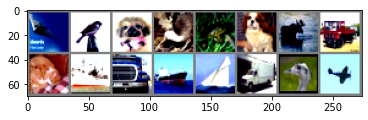

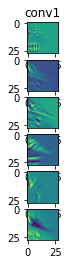

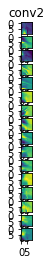

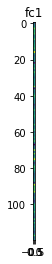

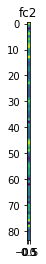

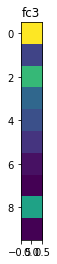

In [8]:
#---------------------------------------------------------------------------------------------
# Get random train images & Visualize feature maps of the first image
dataiter = iter(validationloader)
images, labels = dataiter.next()

# print labels
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(my_batch_size)))
outputs = best_net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]] for j in range(my_batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))

activation = {}
def get_activation(name_capa):
    def hook(model, input, output):
        activation[name_capa] = output.detach()
    return hook

for name_capa, m in best_net._modules.items():
    m.register_forward_hook(get_activation(name_capa))
    output = best_net(images[0].unsqueeze(0))
    act = activation[name_capa].squeeze()
    # print(name_capa)
    # print('Output size = ', act.size())
    if 'conv' in name_capa:
        fig, axarr = plt.subplots(act.size(0))
        for idx in range(act.size(0)):
            if idx == 0:
                axarr[idx].set_title(name_capa)
            axarr[idx].imshow(act[idx])
    if 'fc' in name_capa:
        fig, axarr = plt.subplots() # 1 subplot
        plt.title(name_capa)
        axarr.imshow(act.view(act.size(0),1))
plt.show(block=True)

# References
+ [Python documentation](https://docs.python.org/es/3/)
+ [Numpy documentation](https://numpy.org/doc/)
+ [OpenCV documentation](https://docs.opencv.org/4.4.0/d9/df8/tutorial_root.html)
+ [Pytorch documentation](https://pytorch.org/docs/stable/index.html)